In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

**Walk-Forward Validation**

*   Segment your historical data into a series of training and testing sets that "walk forward"in time.
*   Always train on historical data and test on subsequent, unseen data.
*   Mimic real-world conditions where future information is not available at the time of decision-making.





[*********************100%%**********************]  4 of 4 completed


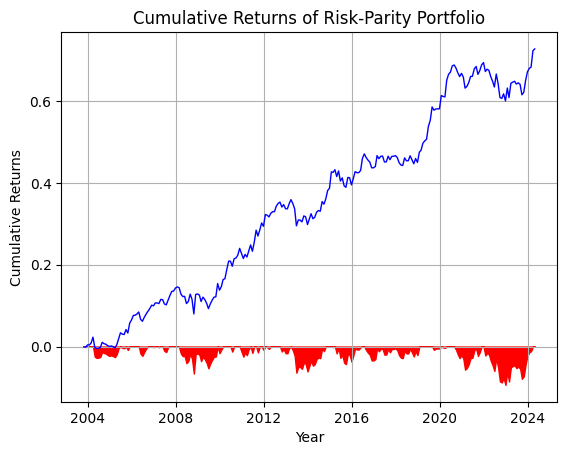


Annualized Mean Return: 0.026565598798318525
Annualized Volatility: 0.036180081989127005
Skewness: 0.08654873589605752
Kurtosis: 1.1153116987624192
Maximum Drawdown: 0.09380057598125147
Sharpe Ratio: 0.734260326062891
Sortino Ratio: 1.199681050036934
Calmar Ratio: 0.09380057598125147


In [ ]:
# Import and prepare data
tickers = ['ES=F','ZN=F','GC=F','DX=F']
prices = yf.download(tickers)['Adj Close']
prices = prices.resample('M').last()
prices = prices.ffill().dropna()

# Calculate returns
returns = np.log(prices).diff().dropna()

# Measure volatility for each asset over time
window_size = 36  # 36 months
rolling_std = returns.rolling(window_size).std().dropna()

# Obtain inverse volatility
rolling_inverse_std = 1/ rolling_std    # assets with lower volatility are allocated with more weight

# Calculate risk-parity asset weights (assets are weighted according to their risk)

compute_weights = lambda column: column / rolling_inverse_std.sum(1)  # 'lambda' = anonymous function, 'column' = argument, (axis =) 1 = columns
    # divide the inverse volatility of each asset by the sum of the inverse volatilities of all asset

risk_parity_weights = rolling_inverse_std.apply(compute_weights)
  # apply = applies the function to each COLUMN
  # normalize the inverse volatilities to ensure that the sum of the weights = 1
  # so basically we are dividing each cell in a row by the sum of all cells

risk_parity_weights = risk_parity_weights.shift(1).dropna()
  # shifts the weights forward by one period so that the weights used for a given period are based on info available at the end of the previous period
  # (i.e., you can't use information that you would only have at the end of the current period to weight the current period)

# Build our portfolio
weighted_returns = (returns * risk_parity_weights).dropna()
portfolio_returns = weighted_returns.sum(axis=1)

# Evaluate performance on unseen data
annualized_mean_return = portfolio_returns.mean() * 12
annualized_volatility = portfolio_returns.std() * np.sqrt(12)
skewness = portfolio_returns.skew()
kurtosis = portfolio_returns.kurt()   # this gives excess kurtosis (check on the function info)
cum_portfolio_returns = np.exp(portfolio_returns.cumsum()) - 1
ongoing_drawdown = cum_portfolio_returns.cummax() - cum_portfolio_returns
max_drawdown = (ongoing_drawdown).max()

# Assume risk-free rate = 0
sharpe_ratio = (annualized_mean_return - 0)/annualized_volatility
#information_ratio
sortino_ratio = (annualized_mean_return - 0)/(portfolio_returns[portfolio_returns<0].std() * np.sqrt(12))
calmar_ratio = annualized_mean_return/max_drawdown

# Plot cumulative returns vs. drawdown
plt.plot(cum_portfolio_returns, label= 'Cumulative Returns', color = 'blue', linewidth = 1)
plt.fill_between(ongoing_drawdown.index, -ongoing_drawdown, color = 'red')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns of Risk-Parity Portfolio')

plt.grid()
print()
plt.show()

# Print performance metrics
print()
print('Annualized Mean Return:', annualized_mean_return)
print('Annualized Volatility:', annualized_volatility)
print('Skewness:', skewness)
print('Kurtosis:', kurtosis)
print('Maximum Drawdown:', max_drawdown)
print('Sharpe Ratio:', sharpe_ratio)
print('Sortino Ratio:', sortino_ratio)
print('Calmar Ratio:', max_drawdown)